In [22]:
from google.colab import drive
!pip install tqdm
from tqdm import tqdm
import torch
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare Shecspir Dataset

In [23]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# generate datasets
context_length = 32
eval_iters = 200

chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - context_length, (batch_size,))
    x = torch.stack([data[i:i+context_length] for i in ix])
    y = torch.stack([data[i+1:i+context_length+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

--2025-01-20 13:11:02--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.11’

input.txt.11        100%[===================>]   1.06M  --.-KB/s    in 0.08s   

2025-01-20 13:11:02 (12.9 MB/s) - ‘input.txt.11’ saved [1115394/1115394]



# Model Parts

In [24]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert embed_dim % num_heads == 0, "Embedding should be divisible on heads"

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.qkv = nn.Linear(embed_dim, 3 * embed_dim)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.scale = self.head_dim ** -0.5

    def forward(self, x, mask=None):
        batch_size, seq_len, embed_dim = x.shape

        qkv = self.qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: t.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2), qkv)

        attn = torch.matmul(q, k.transpose(-2, -1)) * self.scale

        if mask is not None:
            mask = mask.unsqueeze(0).unsqueeze(1)
            mask = mask.expand(batch_size, self.num_heads, seq_len, seq_len)
            attn = attn.masked_fill(~mask, float('-inf'))

        attn = F.softmax(attn, dim=-1)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = out.transpose(1, 2).reshape(batch_size, seq_len, embed_dim)
        out = self.proj(out)

        return out

class FeedFoward(nn.Module):
  def __init__(self, dim, hidden_dim):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(dim, hidden_dim),
        nn.GELU(),
        nn.Dropout(dropout),
        nn.Linear(hidden_dim, dim),
        nn.Dropout(dropout)
    )
    self.norm = nn.LayerNorm(dim)

  def forward(self, x):
    return self.norm(x + self.net(x))


class Block(nn.Module):
    def __init__(self, n_embd, n_hidden_embd, n_head):
        super().__init__()
        self.sa = MultiHeadAttention(n_embd, n_head)
        self.ffwd = FeedFoward(n_embd, n_hidden_embd)
        self.ln1 = nn.LayerNorm(n_embd)

    def forward(self, x, mask=None):
        x = x + self.sa(self.ln1(x), mask)
        x = self.ffwd(x)
        return x

# Model

In [25]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(context_length, n_embd)
        self.embedding_dropout = nn.Dropout(dropout)

        self.blocks = nn.Sequential(*[Block(n_embd, n_hidden_embd, n_head=n_head) for _ in range(n_layer)])

        self.norm = nn.LayerNorm(n_embd)

        self.norm = nn.LayerNorm(n_embd)

        self.classifier = nn.Sequential(
          nn.Linear(n_embd, n_embd * 2),
          nn.LayerNorm(n_embd * 2),
          nn.GELU(),
          nn.Dropout(dropout),

          nn.Linear(n_embd * 2, n_embd),
          nn.LayerNorm(n_embd),
          nn.GELU(),
          nn.Dropout(dropout),

          nn.Linear(n_embd, vocab_size)
        )

    def forward(self, idx, targets=None):
        B, T = idx.shape

        mask = self.create_attention_mask(T).to(device)

        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.embedding_dropout(x)
        for block in self.blocks:
          x = block(x, mask)
        x = self.norm(x)

        logits = self.classifier(x)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def create_attention_mask(self, seq_len):
      mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()
      mask = ~mask
      return mask

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last context_length tokens
            idx_cond = idx[:, -context_length:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

# Model Initialisation and training

In [72]:
@torch.no_grad()
def estimate_loss(eval_iters):
    out = {}
    model.eval()
    for split in ['val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [75]:
#  model parameters
context_length = 32
n_embd = 64
n_hidden_embd = 64 * 4
n_head = 4
n_layer = 4
dropout = 0.0
# training parameters
batch_size = 16
max_iters = 5000
learning_rate = 1e-3
eval_iters = 200
eval_interval = 500
num_epochs = 5
accumulation_steps = 1
steps_per_epoch = len(train_data) // (context_length * batch_size)
max_grad_norm = 1.0


device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [78]:
train_losses = []
validation_losses = []

In [77]:
def train_model(model, optimizer):
  # scheduler = torch.optim.lr_scheduler.OneCycleLR(
  #     optimizer,
  #     max_lr=config['learning_rate'],
  #     epochs=config['num_epochs'],
  #     steps_per_epoch=config['steps_per_epoch'],
  #     pct_start=0.1,
  #     anneal_strategy='cos'
  # )

  best_loss = float('inf')
  validation_loss = 0

  for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    optimizer.zero_grad()
    pbar = tqdm(range(steps_per_epoch), desc=f'Epoch {epoch+1}/{num_epochs}')

    for step in pbar:
      xb, yb = get_batch('train')

      logits, loss = model(xb, yb)

      loss = loss / accumulation_steps
      loss.backward()

      if (step + 1) % accumulation_steps == 0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        optimizer.zero_grad()
        # scheduler.step()

      if (step + 1) % eval_interval == 0 or iter == max_iters - 1:
        validation_loss = estimate_loss(eval_iters)['val'].item()
        validation_losses.append(validation_loss)

      epoch_loss += loss.item() * accumulation_steps
      train_losses.append(loss.item() * accumulation_steps)

      pbar.set_postfix({'loss': f'{epoch_loss/(step+1):.4f}', "v_loss": validation_loss})

    avg_epoch_loss = epoch_loss / steps_per_epoch

    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss,
        }, 'best_model.pth')

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_epoch_loss:.4f}, LR: {learning_rate}')

  return train_losses

0.227457 M parameters


Epoch 1/5: 100%|██████████| 1960/1960 [01:41<00:00, 19.36it/s, loss=2.1220, v_loss=2]


Epoch 1/5, Loss: 2.1220, LR: 0.001


Epoch 2/5: 100%|██████████| 1960/1960 [01:38<00:00, 19.88it/s, loss=1.7303, v_loss=1.86]


Epoch 2/5, Loss: 1.7303, LR: 0.001


Epoch 3/5: 100%|██████████| 1960/1960 [01:39<00:00, 19.71it/s, loss=1.6304, v_loss=1.8]


Epoch 3/5, Loss: 1.6304, LR: 0.001


Epoch 4/5: 100%|██████████| 1960/1960 [01:38<00:00, 20.00it/s, loss=1.5805, v_loss=1.76]


Epoch 4/5, Loss: 1.5805, LR: 0.001


Epoch 5/5: 100%|██████████| 1960/1960 [01:38<00:00, 19.87it/s, loss=1.5492, v_loss=1.74]


Epoch 5/5, Loss: 1.5492, LR: 0.001


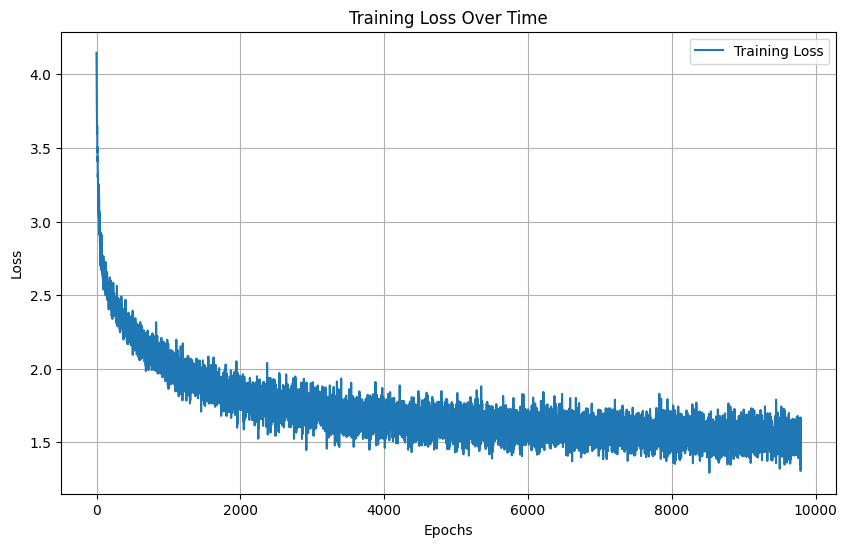

In [79]:
model = Model()
model = model.to(device)
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=learning_rate,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0.01
)

train_losses = train_model(model, optimizer)

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Using model

In [80]:
def load_best_model(model, path='best_model.pth'):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model, checkpoint['loss']

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=2000)[0].tolist()))



Can ColwitES:
Poor spotent:
A numble is thy oof Strain'd,--'tis act in itsea?
Before the eaked; and makes
Which not not you will: he clearl, thou by have yours
I maggle heep an showar wear art; his you with them
the hear their hotest now the commised
Amend in honourue that thone
That, and; ave the grace
Give desires him?

Bid this hearing geated the citize lustingning yours
That spoison, thus lose you have fatter'd ne'em!
And thou, sing good ele. I'll matters,
Taket obducens us more time that blay dargand
To reamlys; and Your a horse: heat mare not; who heir; manusion'd each,
For young me, this
fasters else of us not in
Bettered yousterful plact: your hand heresoling.

DUCHESS OF YORK:
Besome till perty of Rome, I ull.
Yet.

SICINIUS:
Thy lease spreatune's eagure and thou sea let,
And my goot whither's hold chaughts:
Thy telmains, now and when in her?

Swilt:
Think Romen matibles, our good of solven him.

HENRY BOLINGBRown I:
whither, but it
How
What dours, Poling and what he hast boo